In [15]:
import numpy as np
from scipy import integrate
from numpy import linalg as LA
from matplotlib import pyplot as plt

# single site lead (analytic solution)
$\begin{equation}
    \Delta = \frac{E-E_0}{2t}
\end{equation}$
$G_\mathrm{lead}(E) = \begin{cases}
    \frac{\Delta - \sqrt{\Delta^2-1}}{t} \quad (\Delta \geq 1)\\
    \frac{\Delta -i\sqrt{1-\Delta^2}}{t} \quad (-1< \Delta < 1)\\
    \frac{\Delta + \sqrt{\Delta^2-1}}{t} \quad (\Delta \leq -1)\\
\end{cases}$

In [16]:
def G_lead_end0_numerical(E,delta=1e-3,E0=0,t=1):
    dE = lambda u: E-E0-2*t*u
    G_init_w = lambda u: np.sqrt(1-u**2)/(dE(u)**2+delta**2)
    G_init_re = lambda u: 2*dE(u)*G_init_w(u)
    G_init_im = lambda u: -2*delta*G_init_w(u)
    G_re = integrate.quad(G_init_re,-1,1)[0]/np.pi
    G_im = integrate.quad(G_init_im,-1,1)[0]/np.pi
    return complex(G_re,G_im)

def self_energy_lead(E,V,delta=1e-3,E0=0,t=1):
    return np.outer(np.outer(V,np.array([G_lead_end0(E,delta,E0,t)])),V)

In [17]:
def G_lead_end0(E,E0,t):
    D = (E-E0)/(2*t)
    if(D>=1): return complex((D-np.sqrt(D**2-1))/t,0)
    if(abs(D)<1): return complex(D,-np.sqrt(1-D**2))/t
    return complex((D+np.sqrt(D**2-1))/t,0)

In [18]:
E_arr = np.linspace(-10,10,2**7)
Gr_ref = np.array([ G_lead_end0_numerical(E,delta=1e-3).real for E in E_arr ])
Gi_ref = np.array([ G_lead_end0_numerical(E,delta=1e-3).imag for E in E_arr ])
Gr = np.array([ G_lead_end0(E,0,1).real for E in E_arr ])
Gi = np.array([ G_lead_end0(E,0,1).imag for E in E_arr ])

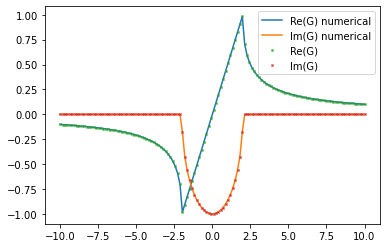

In [19]:
plt.plot(E_arr,Gr_ref,label="Re(G) numerical")
plt.plot(E_arr,Gi_ref,label="Im(G) numerical")
plt.plot(E_arr,Gr,label="Re(G)",marker="x",ms=2,lw=0)
plt.plot(E_arr,Gi,label="Im(G)",marker="x",ms=2,lw=0)
plt.legend()

# Self energy for lead Green function
$G_0 = (E+i\delta-H_0)^{-1}$

$A[0] =G_0 V^\dagger, B[0]=G_0 V$

$A[i+1] =(1-A[i]B[i]-B[i]A[i])^{-1}A[i]A[i]$

$B[i+1] =(1-A[i]B[i]-B[i]A[i])^{-1}B[i]B[i]$

$T_A = A[0] + B[0]A[1] + B[0]B[1]A[2] + \cdots + B[0]B[1] \cdots B[n-1]A[n]$

$T_B = B[0] + A[0]B[1] + A[0]A[1]B[2] + \cdots + A[0]A[1] \cdots A[n-1]B[n]$

$G_\mathrm{right} = (E + i \delta - H_0 - V T_A )^{-1}$

$G_\mathrm{left} = (E + i \delta - H_0 - V^\dagger T_B )^{-1}$ 

In [20]:
def self_energy_in_G_lead(E,H0,V,n_iter,delta=1e-3):
    dagger = lambda M: np.conj(M.T)
    dim = len(H0)
    I = np.identity(dim).astype("complex")
    Zero = np.zeros((dim,dim)).astype("complex")
    G0 = LA.inv( complex(E,delta)*I - H0 )
    A = G0.dot(dagger(V)); B = G0.dot(V)
    # multiplication of A[0]*...*A[n]
    AA = I.copy(); BB = I.copy()
    Asum = Zero.copy(); Bsum = Zero.copy()
    for i in  range(n_iter):
        Asum += BB.dot(A); Bsum += AA.dot(B);  
        AA = AA.dot(A); BB = BB.dot(B)
        W = LA.inv( I - A.dot(B) - B.dot(A) )
        A = W.dot(A.dot(A)); B = np.dot( W, B.dot(B) );
    return V.dot(Asum), dagger(V).dot(Bsum)

def G_all(E,H0,self_energy,delta=1e-3):
    G_inv = complex(E,delta)*np.identity(len(H0)).astype("complex") - H0 - self_energy
    return LA.inv(G_inv) 
    

In [21]:
H0 = np.array([ [0,0],[0,0] ]).astype("complex")
V = np.array([ [0,1],[1,0] ]).astype("complex")
self_energy_recursive = np.array([ self_energy_in_G_lead(E,H0,V,2**10,delta=1e-3)[0] for E in  E_arr ])
G_recursive = np.array([ G_all(E,H0,self_energy,delta=1e-3)[0][0] for 
E,self_energy in  zip(E_arr,self_energy_recursive) ])

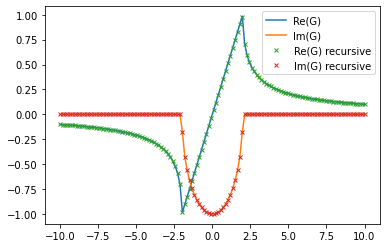

In [22]:
plt.plot(E_arr,Gr,label="Re(G)")
plt.plot(E_arr,Gi,label="Im(G)")
plt.plot(E_arr,G_recursive.real,label="Re(G) recursive",marker="x",ms=4,lw=0)
plt.plot(E_arr,G_recursive.imag,label="Im(G) recursive",marker="x",ms=4,lw=0)
plt.legend()